In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [15]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [16]:
df = pd.read_csv("../../../our_analyses/dataset_prepared.csv")

In [17]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)
df['genre'] = pd.factorize(df['genre'])[0]
y = np.array(df["genre"])
df = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
X = df.values

In [18]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_minmax)

In [20]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

### FInd the best number of cluster

In [21]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

silhouette_scores = []
for k in range(2, 11):  # Prova con un numero di cluster da 2 a 10
    model = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = model.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Trova il numero ottimale di cluster
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Numero ottimale di cluster:", optimal_k)

# Ora puoi creare il modello con il numero ottimale di cluster
model = AgglomerativeClustering(n_clusters=optimal_k, linkage='complete')


Numero ottimale di cluster: 2


### Find the best distance threshold

In [22]:
# Range di valori per testare il distance_threshold
threshold_range = np.linspace(start=0.1, stop=3.0, num=20)

best_silhouette = -1
best_threshold = None

for threshold in threshold_range:
    model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, metric="euclidean", linkage='complete')
    model = model.fit(X_pca)
    labels = model.labels_
    if len(set(labels)) > 1:  # Assicurati che ci siano almeno 2 cluster
        silhouette_avg = silhouette_score(X_pca, labels)
        print("Threshold:", threshold, "Silhouette:", silhouette_avg)
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_threshold = threshold

print("Miglior distance_threshold:", best_threshold, "con silhouette di:", best_silhouette)


Threshold: 0.1 Silhouette: 0.25946062125935265
Threshold: 0.25263157894736843 Silhouette: 0.19418025000019595
Threshold: 0.4052631578947369 Silhouette: 0.1532184489073896
Threshold: 0.5578947368421052 Silhouette: 0.13865554259905305
Threshold: 0.7105263157894737 Silhouette: 0.13924968312633326
Threshold: 0.8631578947368421 Silhouette: 0.14294153560783077
Threshold: 1.0157894736842106 Silhouette: 0.14710567491646467
Threshold: 1.168421052631579 Silhouette: 0.14936105823647414
Threshold: 1.3210526315789475 Silhouette: 0.17165614288999687
Threshold: 1.473684210526316 Silhouette: 0.17575966316167804
Threshold: 1.6263157894736844 Silhouette: 0.16464313328865773
Threshold: 1.7789473684210528 Silhouette: 0.13430099390783234
Threshold: 1.931578947368421 Silhouette: 0.13101213017065053
Threshold: 2.0842105263157893 Silhouette: 0.16372950008567325
Threshold: 2.236842105263158 Silhouette: 0.1062091609154726
Threshold: 2.3894736842105266 Silhouette: 0.11229261866201803
Threshold: 2.542105263157895

### Try firstly with no specific values

The dendrogram using complete linkage with the Euclidean distance metric depicts a hierarchical structure where clusters are merged based on the maximum distance between objects in different clusters. In this visualization, we see several clusters that merge at varying heights, indicating the diverse distances at which clusters join together.

The complete linkage method tends to create more balanced dendrograms, as it avoids the chaining effect seen in single linkage. This can be observed in the relatively even distribution of cluster merges across different levels of similarity. The high-level merges, indicated by the blue lines at the top of the dendrogram, suggest that there are substantial differences between the most distinct clusters.

The Euclidean distance is a more conventional choice for datasets where the geometric properties of the data are essential, and it is often used when the data is low-dimensional. However, it can also be used effectively in higher dimensions, albeit sometimes being sensitive to noise and outliers.

This dendrogram suggests that there is a relatively clear distinction between clusters, with some clusters merging at low similarity levels (low height merges) and others requiring a higher threshold to combine (high height merges). The structure of the dendrogram could be indicative of a dataset with distinct groupings where the maximum difference between members dictates cluster formation.

In the context of selecting a number of clusters, one might consider cutting the dendrogram at a height that would separate the most distinct groups, which in this case could be just before the largest merges at the top.

Ultimately, the appropriateness of this dendrogram depends on the specific context and characteristics of the data, as well as how the clusters formed align with the practical objectives of the clustering. Comparing this dendrogram with those from other linkage methods and distance metrics would provide a comprehensive view of how different approaches partition the data.

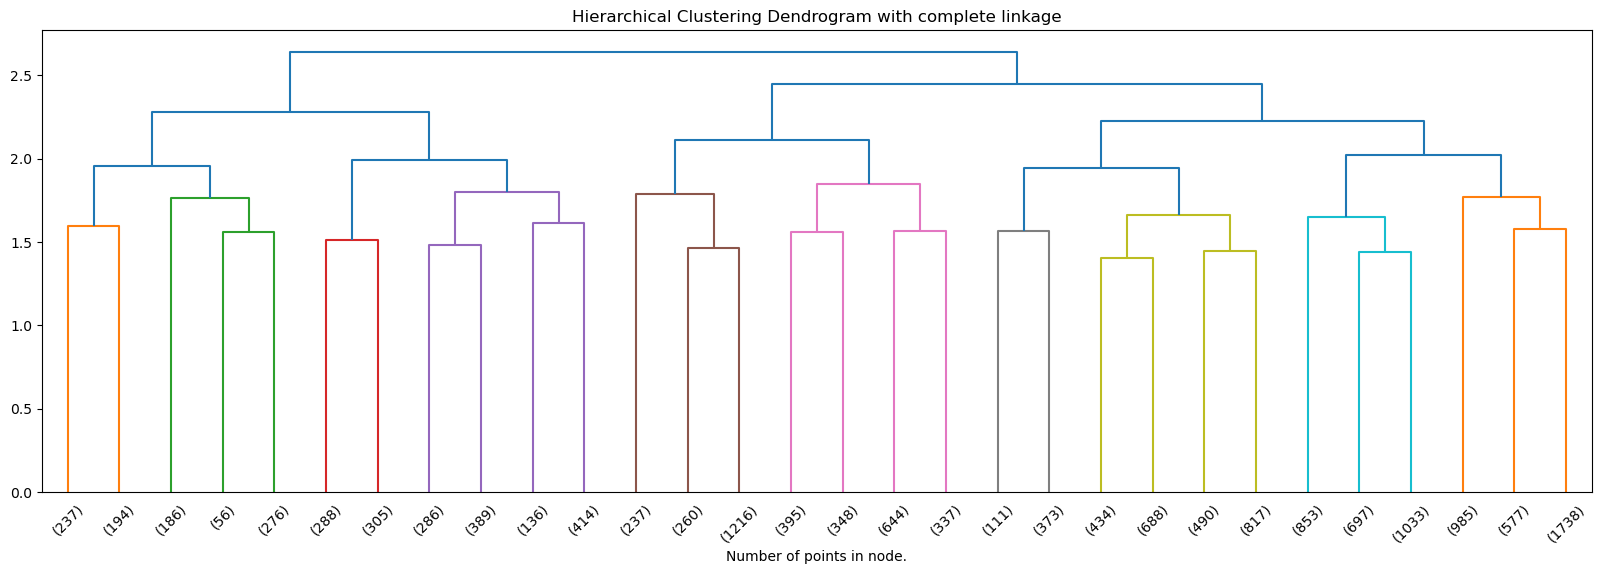

In [27]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                metric='euclidean', linkage='complete')
model = model.fit(X_pca)

plt.figure(figsize=(20, 6))
plt.title("Hierarchical Clustering Dendrogram with complete linkage")
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel("Number of points in node.")
plt.show()

### Calculate Silhoutte

In [24]:
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=1.473684210526316, criterion='distance')

print('Silhouette', silhouette_score(X_pca, labels))

Silhouette 0.17575966316167804


### Choosing the number of clusters

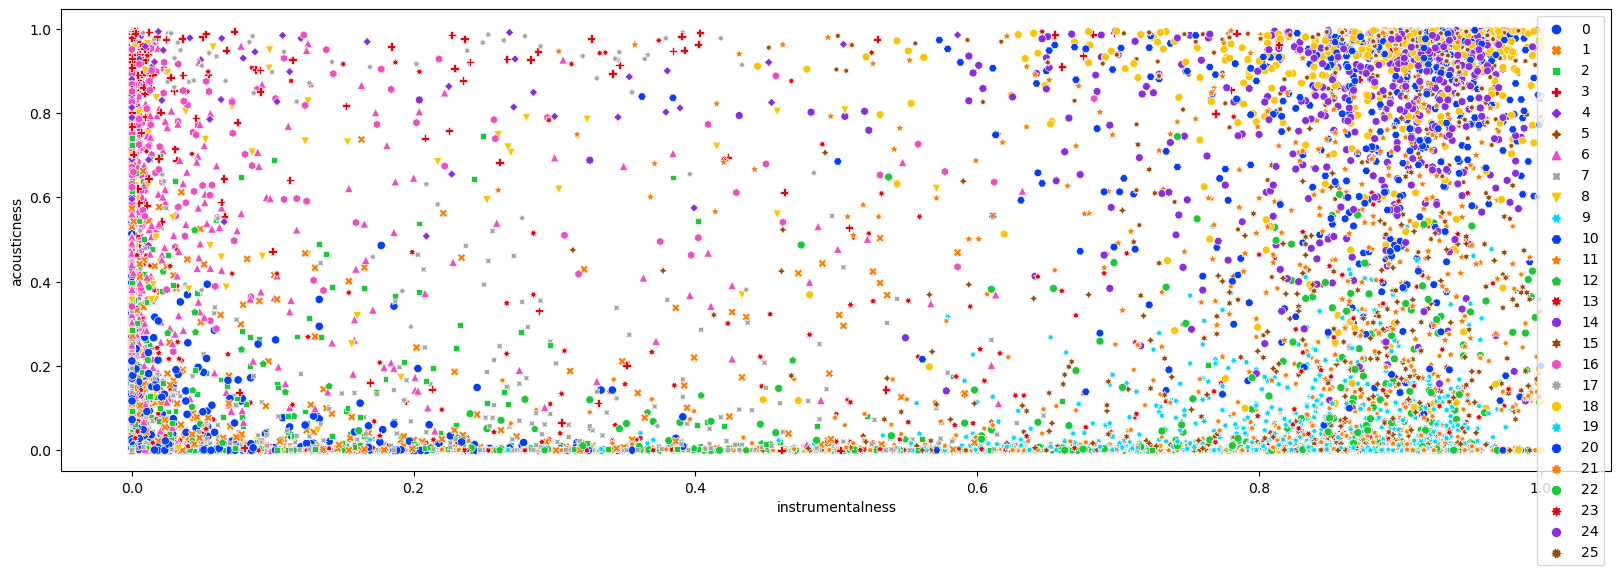

In [25]:
hier = AgglomerativeClustering(distance_threshold=1.473684210526316, n_clusters=None, metric="euclidean", linkage='complete')
hier.fit(X_pca)

plt.figure(figsize=(20, 6))

sns.scatterplot(data=df, 
                x="instrumentalness",
                y="acousticness", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()

### connectivity in Clustering Gerarchico
Nel contesto del clustering gerarchico, connectivity è una matrice che definisce la struttura dei dati o il modo in cui i punti dati sono connessi tra loro. Questa connettività può influenzare come i cluster vengono formati durante l'algoritmo di clustering.

kneighbors_graph: Questa funzione costruisce una matrice di connettività basata sui k vicini più prossimi di ciascun punto. In questo caso, n_neighbors=100 significa che per ogni punto dati, stai considerando i suoi 100 vicini più prossimi per definire la connettività.

include_self=False: Indica che il punto stesso non dovrebbe essere incluso nei suoi vicini più prossimi.

Utilizzare una matrice di connettività nel clustering gerarchico è utile per considerare solo certe relazioni tra i punti, ad esempio per imporre una struttura di vicinato o per lavorare con dati che hanno una struttura di rete o grafica intrinseca.

In [26]:
from sklearn.cluster import AgglomerativeClustering

# Esegui l'Hierarchical Clustering
model = AgglomerativeClustering(distance_threshold=1.473684210526316, n_clusters=None, metric="euclidean", linkage='complete')
model = model.fit(X_pca)

# Assegna le etichette dei cluster dal modello di Hierarchical Clustering
hierarchical_cluster_labels = model.labels_

# Crea una nuova colonna nel DataFrame per i cluster
df['cluster'] = hierarchical_cluster_labels

# Dato che 'genre' è stato rimosso da df e salvato in y, aggiungiamo 'genre' di nuovo a df
df['genre'] = y

# Calcolare la frequenza di ogni genere in ciascun cluster
cluster_genre_counts = df.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Calcolare la dimensione di ogni cluster
cluster_sizes = df['cluster'].value_counts()

# Calcolare le proporzioni relative di ogni genere all'interno dei cluster
cluster_genre_proportions = cluster_genre_counts.div(cluster_sizes, axis=0)

# Determinare il cluster dominante per ogni genere basandosi sulle proporzioni
dominant_cluster_per_genre = cluster_genre_proportions.idxmax(axis=0)

print(dominant_cluster_per_genre)


genre
0      9
1     12
2     16
3      8
4     19
5      9
6     17
7     13
8     12
9     10
10     4
11    12
12    10
13     2
14     7
15    16
16    18
17     8
18    20
19    19
dtype: int64
